# VoxelNet Geothermal - Demo Notebook

This notebook demonstrates how to:
1. Load the pretrained model
2. Run 29-step autoregressive rollout
3. Evaluate model accuracy

**Prerequisites:**
- Install dependencies: `pip install -r requirements.txt`
- Download sample data from [Google Drive](https://drive.google.com/drive/folders/1CqXxoEauRxgvNbHOnKDVaLhkRWTlsXsg) and place in `sample_data/`

In [23]:
import sys
import os

# Add repo root to path
sys.path.insert(0, os.path.abspath('..'))

import torch
import json

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.4.0+cu121
CUDA available: True


## Configuration

In [24]:
# Paths (relative to notebooks/ directory)
CHECKPOINT_PATH = "../checkpoints/best_r5_step53000.pt"
STATS_PATH = "../data/stats.json"
DATA_DIR = "../sample_data"

# Use all available test files for better accuracy
TEST_FILES = ["v2.5_0001.h5", "v2.5_0002.h5"]

# Device
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# Verify files exist
print("\nChecking files:")
for path, name in [(CHECKPOINT_PATH, "Checkpoint"), (STATS_PATH, "Stats")]:
    exists = os.path.exists(path)
    status = "OK" if exists else "MISSING"
    print(f"  {name}: {path} [{status}]")

print(f"\nTest files in {DATA_DIR}:")
for f in TEST_FILES:
    path = f"{DATA_DIR}/{f}"
    exists = os.path.exists(path)
    status = "OK" if exists else "MISSING"
    print(f"  {f} [{status}]")

Using device: cuda:0

Checking files:
  Checkpoint: ../checkpoints/best_r5_step53000.pt [OK]
  Stats: ../data/stats.json [OK]

Test files in ../sample_data:
  v2.5_0001.h5 [OK]
  v2.5_0002.h5 [OK]


## Load Model

Import `load_model_from_checkpoint` from `scripts/rollout.py` to ensure correct model loading.

In [25]:
from scripts.rollout import load_model_from_checkpoint

# Load stats
with open(STATS_PATH, 'r') as f:
    stats = json.load(f)

print(f"Static channels: {stats['static_channels']}")
print(f"Grid channels: {stats['grid_channels']}")

# Load model
model, step = load_model_from_checkpoint(CHECKPOINT_PATH, stats, DEVICE)
print(f"\nModel loaded from step {step}")

Static channels: ['FaultId', 'InjRate', 'IsActive', 'IsWell', 'PermX', 'PermY', 'PermZ', 'Porosity']
Grid channels: ['Pressure', 'Temperature', 'WEPT']
Loading checkpoint from ../checkpoints/best_r5_step53000.pt...
Created VoxelAutoRegressor model with base_channels=32, r=5 (kernel 11x11x11)
Loaded model from step 53000
Model parameters: 849,000

Model loaded from step 53000


## Run 29-Step Autoregressive Rollout

Import `evaluate_rollout` from `scripts/train_ddp.py` which handles normalization correctly.

In [26]:
from scripts.train_ddp import evaluate_rollout

print(f"Running 29-step autoregressive rollout on {len(TEST_FILES)} files...")
print()

metrics = evaluate_rollout(
    model=model,
    raw_h5_dir=DATA_DIR,
    stats=stats,
    device=DEVICE,
    test_files=TEST_FILES,
    max_steps=29
)

print("\n" + "="*60)
print(f"ROLLOUT RESULTS (29 steps, {len(TEST_FILES)} files)")
print("="*60)
print(f"Pressure    - Acc5: {metrics['rollout/acc5_p']*100:.1f}%  MSE: {metrics['rollout/mse_p']:.2f}")
print(f"Temperature - Acc5: {metrics['rollout/acc5_t']*100:.1f}%  MSE: {metrics['rollout/mse_t']:.2f}")
print(f"WEPT        - Acc5: {metrics['rollout/acc5_w']*100:.1f}%  MSE: {metrics['rollout/mse_w']:.2e}")
print("="*60)
print("\nNote: README reports 84.1% P, 86.7% T on 5 test files. We have 2 files.")

Running 29-step autoregressive rollout on 2 files...


ROLLOUT RESULTS (29 steps, 2 files)
Pressure    - Acc5: 73.0%  MSE: 36.66
Temperature - Acc5: 87.4%  MSE: 32.04
WEPT        - Acc5: 43.9%  MSE: 1.24e+25

Note: README reports 84.1% P, 86.7% T on 5 test files. We have 2 files.


## Per-Timestep Evaluation

For detailed per-timestep metrics, use `evaluate_rollout_per_timestep` from `scripts/evaluate.py`.

In [27]:
from scripts.evaluate import evaluate_rollout_per_timestep

print(f"Running per-timestep evaluation on {TEST_FILES[0]}...")

# Returns tuple: (per_timestep_dict, summary_dict)
# per_timestep has keys: P_MSE, T_MSE, W_MSE, P_Acc5, T_Acc5, W_Acc5
# Acc5 values are already in percentage (0-100)
per_timestep, summary = evaluate_rollout_per_timestep(
    model=model,
    raw_h5_dir=DATA_DIR,
    stats=stats,
    device=DEVICE,
    test_files=[TEST_FILES[0]],
    max_steps=29
)

print("\nPer-Timestep Results:")
print("-"*70)
print(f"{'Step':>4} | {'P Acc5':>8} | {'P MSE':>10} | {'T Acc5':>8} | {'T MSE':>10}")
print("-"*70)

for t in range(len(per_timestep.get('P_Acc5', []))):
    p_acc = per_timestep['P_Acc5'][t]  # Already in percentage
    p_mse = per_timestep['P_MSE'][t]
    t_acc = per_timestep['T_Acc5'][t]  # Already in percentage
    t_mse = per_timestep['T_MSE'][t]
    print(f"{t+1:>4} | {p_acc:>7.1f}% | {p_mse:>10.2f} | {t_acc:>7.1f}% | {t_mse:>10.2f}")

Running per-timestep evaluation on v2.5_0001.h5...

Per-Timestep Results:
----------------------------------------------------------------------
Step |   P Acc5 |      P MSE |   T Acc5 |      T MSE
----------------------------------------------------------------------
   1 |   100.0% |       0.07 |    97.1% |       2.36
   2 |   100.0% |       0.16 |    96.5% |       3.16
   3 |   100.0% |       1.08 |    94.9% |       5.95
   4 |    99.8% |       2.56 |    93.7% |       7.28
   5 |    96.1% |       6.11 |    92.3% |       9.86
   6 |    91.8% |       7.96 |    91.4% |      10.56
   7 |    82.2% |      13.68 |    90.3% |      13.26
   8 |    76.1% |      18.40 |    89.4% |      15.08
   9 |    66.2% |      26.06 |    88.6% |      17.82
  10 |    59.8% |      32.00 |    87.9% |      20.53
  11 |    52.8% |      39.70 |    87.2% |      23.69
  12 |    46.9% |      47.90 |    86.6% |      27.13
  13 |    44.9% |      52.79 |    86.0% |      30.23
  14 |    41.4% |      61.64 |    85.5% | 

## Visualization

  Saved predictions to: _demo_predictions.h5


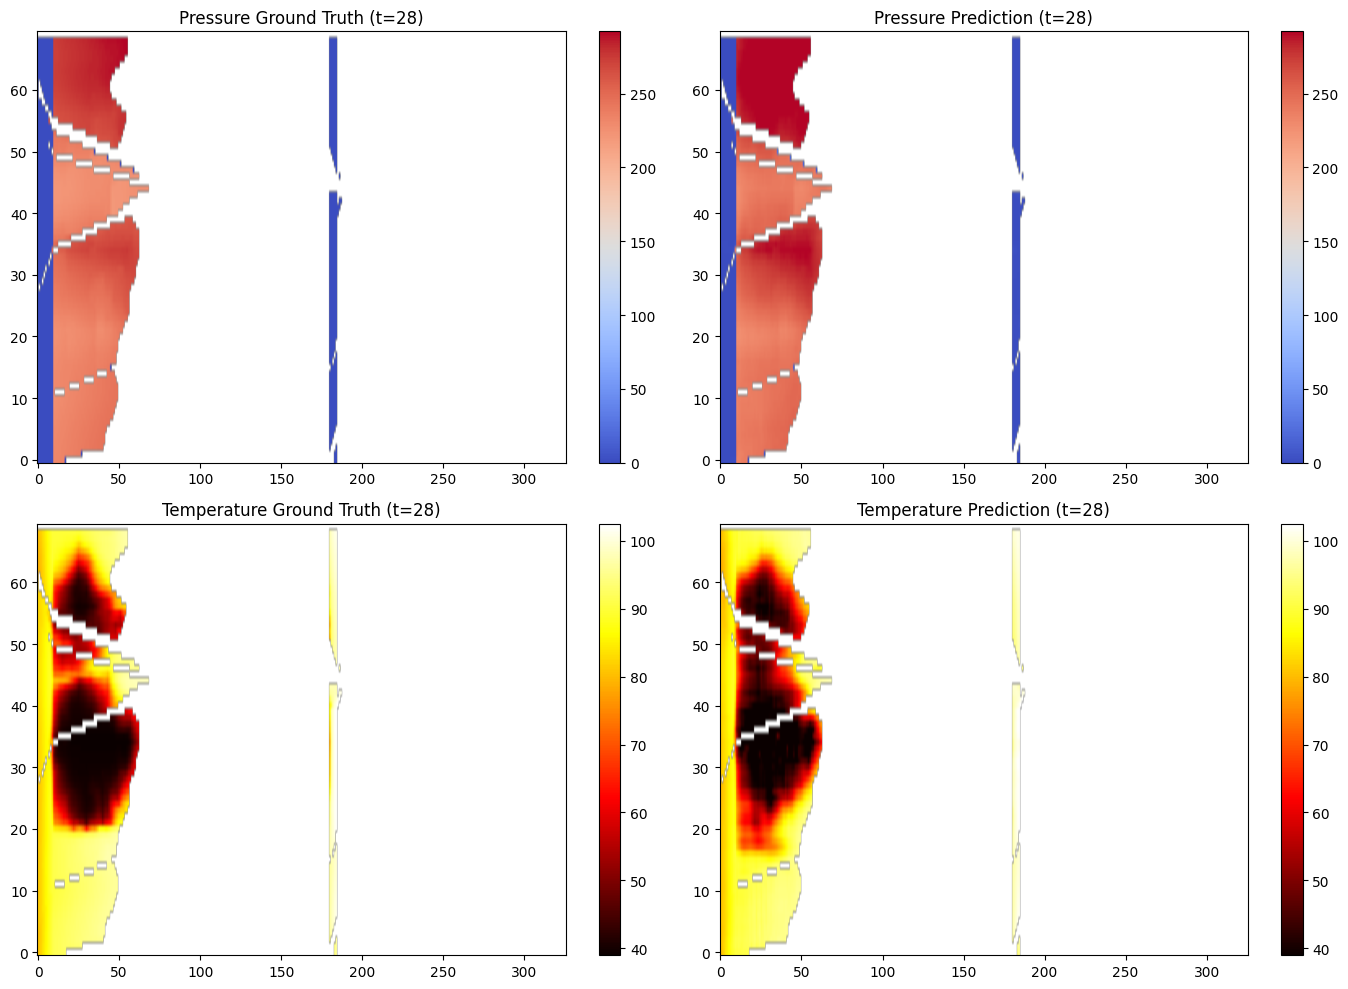

Visualization complete.


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

# Save predictions for visualization
save_path = "_demo_predictions.h5"
_, _ = evaluate_rollout_per_timestep(
    model=model,
    raw_h5_dir=DATA_DIR,
    stats=stats,
    device=DEVICE,
    test_files=[TEST_FILES[0]],
    max_steps=29,
    save_path=save_path
)

# Load and visualize - keys are {filename}/pressure_ar, pressure_true, etc.
with h5py.File(save_path, 'r') as f:
    grp = f[TEST_FILES[0]]
    pred_p = grp['pressure_ar'][:]
    pred_t = grp['temperature_ar'][:]
    gt_p = grp['pressure_true'][:]
    gt_t = grp['temperature_true'][:]

# Show timestep 
t_show = 28
mid_z = pred_p.shape[3] // 2

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Pressure
gt_slice = np.ma.masked_where(gt_p[t_show, :, :, mid_z] == -999, gt_p[t_show, :, :, mid_z])
pred_slice = np.ma.masked_where(gt_p[t_show, :, :, mid_z] == -999, pred_p[t_show, :, :, mid_z])
vmin, vmax = gt_slice.min(), gt_slice.max()

im = axes[0, 0].imshow(gt_slice.T, cmap='coolwarm', origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
axes[0, 0].set_title(f'Pressure Ground Truth (t={t_show})')
plt.colorbar(im, ax=axes[0, 0])

im = axes[0, 1].imshow(pred_slice.T, cmap='coolwarm', origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
axes[0, 1].set_title(f'Pressure Prediction (t={t_show})')
plt.colorbar(im, ax=axes[0, 1])

# Temperature
gt_slice = np.ma.masked_where(gt_t[t_show, :, :, mid_z] == -999, gt_t[t_show, :, :, mid_z])
pred_slice = np.ma.masked_where(gt_t[t_show, :, :, mid_z] == -999, pred_t[t_show, :, :, mid_z])
vmin, vmax = gt_slice.min(), gt_slice.max()

im = axes[1, 0].imshow(gt_slice.T, cmap='hot', origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
axes[1, 0].set_title(f'Temperature Ground Truth (t={t_show})')
plt.colorbar(im, ax=axes[1, 0])

im = axes[1, 1].imshow(pred_slice.T, cmap='hot', origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
axes[1, 1].set_title(f'Temperature Prediction (t={t_show})')
plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.show()

os.remove(save_path)
print("Visualization complete.")

## Command Line Usage

```bash
# Quick evaluation
python scripts/rollout.py --checkpoint checkpoints/best_r5_step53000.pt --test_files v2.5_0001.h5

# Detailed evaluation with saved predictions
python scripts/evaluate.py --checkpoint checkpoints/best_r5_step53000.pt --save_path predictions.h5
```

## Next Steps

- Try smaller model: `../checkpoints/best_r2_step24000.pt`
- Run on both files: `["v2.5_0001.h5", "v2.5_0002.h5"]`
- See `analyze_h5_v2.5_fixed.ipynb` to explore data format
- See `model_error_analysis.ipynb` for error analysis